<a href="https://colab.research.google.com/github/tatsuro-Chiba/covid19/blob/master/3D%E5%BC%BE%E9%81%93%E8%A8%88%E7%AE%97%E8%A1%A8%E7%A4%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
import pycuda.autoinit
import plotly.graph_objects as go

# パラメータ設定
v = 100  # 基本速度
azimuths_deg = np.arange(0, 360, 5).astype(np.float32)  # 方位角（0度から360度を10度刻み）
elevation_angles_deg = np.arange(40, 91, 5).astype(np.float32)  # 射出角度（40度から90度を10度刻み）
CD = 0.47  # 空気抵抗係数
d = 0.3  # 直径 (m)
r = d / 2  # 半径 (m)
A = np.pi * r**2  # 投影面積 (m²)
specific_gravity = 2.2  # 比重
rho = specific_gravity * 1000  # 密度 (kg/m³)
V = (4/3) * np.pi * r**3  # 体積 (m³)
m = rho * V  # 質量 (kg)
rho_air = 1.225  # 空気密度 (kg/m³)
g = 9.81  # 重力加速度 (m/s²)
dt = 0.01  # タイムステップ (秒)
max_time = 100  # 最大シミュレーション時間 (秒)

# CUDAカーネル
kernel_code = SourceModule('''
__global__ void simulate_trajectory(float *azimuths, float *elevations, int num_azimuths, int num_elevations, float *results_x, float *results_y, float *results_z,
                                     float v, float CD, float r, float A, float m, float rho_air, float g, float dt, int max_steps) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int az_idx = idx / num_elevations;
    int el_idx = idx % num_elevations;

    if (az_idx < num_azimuths && el_idx < num_elevations) {
        float azimuth = azimuths[az_idx] * 3.14159265358979 / 180.0;  // 方位角をラジアンに変換
        float elevation = elevations[el_idx] * 3.14159265358979 / 180.0;  // 射出角度をラジアンに変換
        float v0 = v * pow(sinf(elevation), 1.5);  // 初速計算
        float vx = v0 * cosf(elevation) * cosf(azimuth);
        float vy = v0 * cosf(elevation) * sinf(azimuth);
        float vz = v0 * sinf(elevation);
        float x = 0.0;
        float y = 0.0;
        float z = 0.0;

        for (int step = 0; step < max_steps; step++) {
            float v_mag = sqrtf(vx * vx + vy * vy + vz * vz);
            float Fd = 0.5 * CD * rho_air * A * v_mag * v_mag;
            float ax = -Fd / m * (vx / v_mag);
            float ay = -Fd / m * (vy / v_mag);
            float az = -g - (Fd / m) * (vz / v_mag);

            // Euler法で更新
            vx += ax * dt;
            vy += ay * dt;
            vz += az * dt;
            x += vx * dt;
            y += vy * dt;
            z += vz * dt;

            // 結果を保存
            results_x[idx * max_steps + step] = x;
            results_y[idx * max_steps + step] = y;
            results_z[idx * max_steps + step] = z;

            if (z < 0) break;  // 地面に到達したら終了
        }
    }
}
''')

simulate_trajectory = kernel_code.get_function("simulate_trajectory")

# GPUメモリ確保
num_azimuths = len(azimuths_deg)
num_elevations = len(elevation_angles_deg)
total_trajectories = num_azimuths * num_elevations
max_steps = int(max_time / dt)
azimuths_gpu = cuda.mem_alloc(azimuths_deg.nbytes)
elevations_gpu = cuda.mem_alloc(elevation_angles_deg.nbytes)
results_x_gpu = cuda.mem_alloc(total_trajectories * max_steps * np.float32(0).nbytes)
results_y_gpu = cuda.mem_alloc(total_trajectories * max_steps * np.float32(0).nbytes)
results_z_gpu = cuda.mem_alloc(total_trajectories * max_steps * np.float32(0).nbytes)

# データをGPUに転送
cuda.memcpy_htod(azimuths_gpu, azimuths_deg)
cuda.memcpy_htod(elevations_gpu, elevation_angles_deg)

# カーネル呼び出し
block_dim = 32
grid_dim = (total_trajectories + block_dim - 1) // block_dim
simulate_trajectory(
    azimuths_gpu, elevations_gpu, np.int32(num_azimuths), np.int32(num_elevations),
    results_x_gpu, results_y_gpu, results_z_gpu,
    np.float32(v), np.float32(CD), np.float32(r), np.float32(A), np.float32(m),
    np.float32(rho_air), np.float32(g), np.float32(dt), np.int32(max_steps),
    block=(block_dim, 1, 1), grid=(grid_dim, 1)
)

# 結果をホストにコピー
results_x = np.zeros((total_trajectories, max_steps), dtype=np.float32)
results_y = np.zeros((total_trajectories, max_steps), dtype=np.float32)
results_z = np.zeros((total_trajectories, max_steps), dtype=np.float32)
cuda.memcpy_dtoh(results_x, results_x_gpu)
cuda.memcpy_dtoh(results_y, results_y_gpu)
cuda.memcpy_dtoh(results_z, results_z_gpu)

# Plotlyでインタラクティブな3Dプロットを作成
fig = go.Figure()
colors = plt.cm.jet(np.linspace(0, 1, len(elevation_angles_deg)))

for i, el_idx in enumerate(range(len(elevation_angles_deg))):
    for az_idx in range(len(azimuths_deg)):
        trajectory_idx = az_idx * len(elevation_angles_deg) + el_idx
        fig.add_trace(go.Scatter3d(
            x=results_x[trajectory_idx],
            y=results_y[trajectory_idx],
            z=results_z[trajectory_idx],
            mode='lines',
            line=dict(color=f'rgb({colors[i][0]*255},{colors[i][1]*255},{colors[i][2]*255})'),
            #name=f'Elevation {elevation_angles_deg[el_idx]}°'
        ))

# レイアウト設定
fig.update_layout(
    scene=dict(
        xaxis_title='X (m)',
        yaxis_title='Y (m)',
        zaxis_title='Z (m)',
    ),
    title="Interactive 3D Ballistic Trajectories",
)

# 表示
fig.show()

ModuleNotFoundError: No module named 'pycuda'

In [ ]:
import rasterio
from rasterio.transform import from_origin

# 入力ファイルを開く
with rasterio.open('/content/all1m.tif') as src:
    profile = src.profile
    data = src.read()

# 新しい変換行列を設定（例: Y軸を反転）
transform = from_origin(profile['transform'].c, profile['transform'].f, profile['transform'].a, -profile['transform'].e)

profile.update(transform=transform)

# 出力ファイルに書き込む
with rasterio.open('content/all1m-c.tif', 'w', **profile) as dst:
    dst.write(data)

RasterioIOError: '/content/all1m.tif' not recognized as being in a supported file format.

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.2 MB/s eta 0:00:00


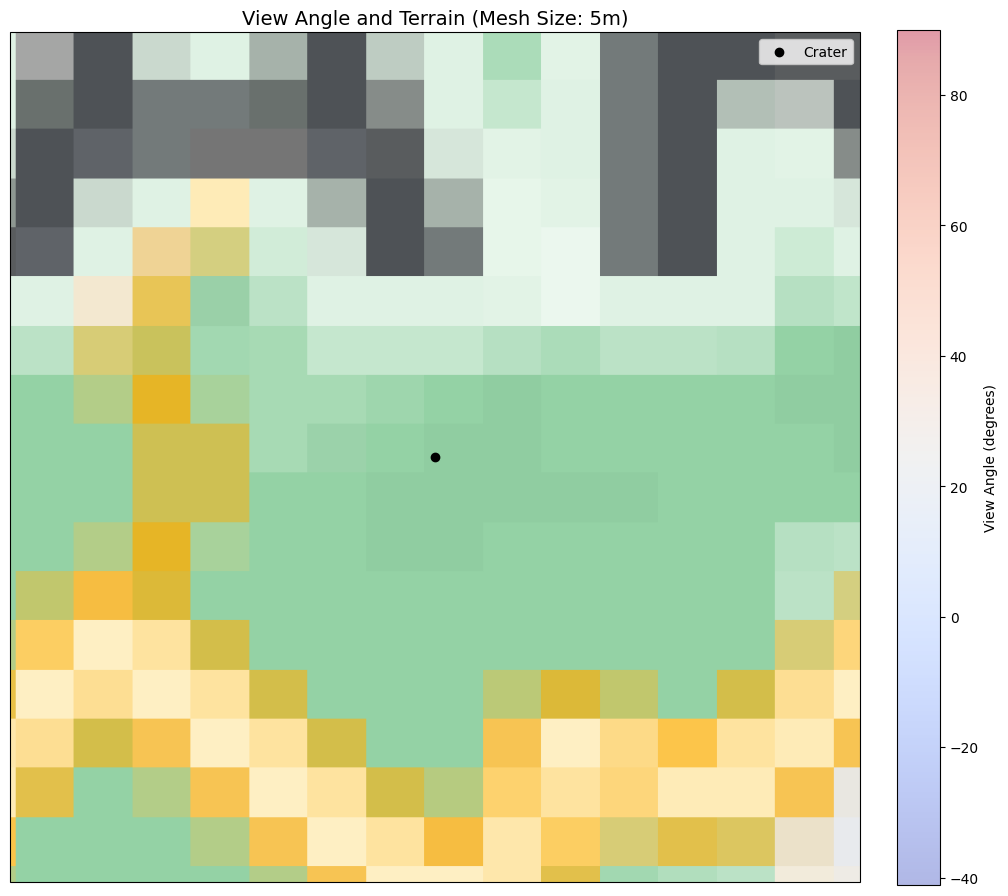

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

# 標高タイルのURLテンプレート
dem_url_template = "https://cyberjapandata.gsi.go.jp/xyz/dem/{z}/{x}/{y}.txt"

# 火口（雲仙普賢岳）の緯度経度と標高を指定
crater_lat, crater_lon = 32.7611, 130.2989  # 雲仙普賢岳の位置
crater_height = 1359  # 火口の標高（m）
zoom = 14  # ズームレベル

# タイル座標計算
def latlon_to_tile(lat, lon, zoom):
    n = 2 ** zoom
    xtile = int((lon + 180.0) / 360.0 * n)
    ytile = int((1.0 - np.log(np.tan(np.radians(lat)) + 1 / np.cos(np.radians(lat))) / np.pi) / 2.0 * n)
    return xtile, ytile

# タイルを取得してマージ
def fetch_and_merge_tiles_corrected(x_center, y_center, z, tile_range):
    tiles = []
    for dy in range(-tile_range, tile_range + 1):  # 縦方向のタイル
        row = []
        for dx in range(-tile_range, tile_range + 1):  # 横方向のタイル
            try:
                x, y = x_center + dx, y_center + dy
                url = dem_url_template.format(z=z, x=x, y=y)
                response = requests.get(url)
                if response.status_code == 200:
                    data = [
                        [float(val) if val != "e" else np.nan for val in line.split(",")]
                        for line in response.text.splitlines()
                    ]
                    row.append(np.array(data, dtype=np.float32))
                else:
                    print(f"Failed to fetch tile at ({x}, {y})")
                    row.append(np.full((256, 256), np.nan))
            except Exception as e:
                print(f"Error fetching tile ({x}, {y}): {e}")
                row.append(np.full((256, 256), np.nan))
        tiles.append(np.hstack(row))  # 横方向に結合
    return np.vstack(tiles)  # 縦方向に結合

# 火口からの見通し角を計算
def calculate_view_angle(dem_data, crater_x, crater_y, crater_height, mesh_size):
    y, x = np.indices(dem_data.shape)
    distance = np.sqrt((x - crater_x)**2 + (y - crater_y)**2) * mesh_size
    height_diff = dem_data - crater_height
    angle = np.degrees(np.arctan2(height_diff, distance))
    return angle

# 火口のタイル座標を計算
xtile, ytile = latlon_to_tile(crater_lat, crater_lon, zoom)

# 火口のピクセル座標を計算
def latlon_to_pixel(lat, lon, xtile, ytile, zoom, tile_range):
    n = 2 ** zoom
    tile_size = 256
    x = (lon + 180.0) / 360.0 * n * tile_size
    y = (1.0 - np.log(np.tan(np.radians(lat)) + 1 / np.cos(np.radians(lat))) / np.pi) / 2.0 * n * tile_size
    return int(x - (xtile - tile_range) * tile_size), int(y - (ytile - tile_range) * tile_size)

tile_range = 2  # 中心タイルからの範囲
crater_x, crater_y = latlon_to_pixel(crater_lat, crater_lon, xtile, ytile, zoom, tile_range)

# 修正版タイル接合を使用
dem_data = fetch_and_merge_tiles_corrected(xtile, ytile, zoom, tile_range)

# 見通し角を計算（メッシュサイズを細かく設定）
mesh_size = 5  # メッシュのサイズ (m) - 5m間隔に変更
view_angle = calculate_view_angle(dem_data, crater_x, crater_y, crater_height, mesh_size)

# 地理院地図を背景に表示
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# 地理院地図（背景）
tiler = GoogleTiles()
ax.add_image(tiler, zoom - 6)

# 地形データを重ねて表示
extent = [
    crater_lon - tile_range * 0.02,
    crater_lon + tile_range * 0.02,
    crater_lat - tile_range * 0.02,
    crater_lat + tile_range * 0.02,
]
terrain = ax.imshow(
    dem_data,
    cmap="terrain",
    alpha=0.6,
    extent=extent,
    transform=ccrs.PlateCarree(),
)

# 見通し角データを重ねて表示
view = ax.imshow(
    view_angle,
    cmap="coolwarm",
    alpha=0.4,
    extent=extent,
    transform=ccrs.PlateCarree(),
)

# 火口位置を表示
ax.scatter(crater_lon, crater_lat, color="black", transform=ccrs.PlateCarree(), label="Crater")

# カラーバー（見通し角）
cbar = plt.colorbar(view, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.set_label("View Angle (degrees)")

# 凡例とタイトル
ax.set_title(f"View Angle and Terrain (Mesh Size: {mesh_size}m)", fontsize=14)
ax.legend()

plt.show()


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 92.8 MB/s eta 0:00:00


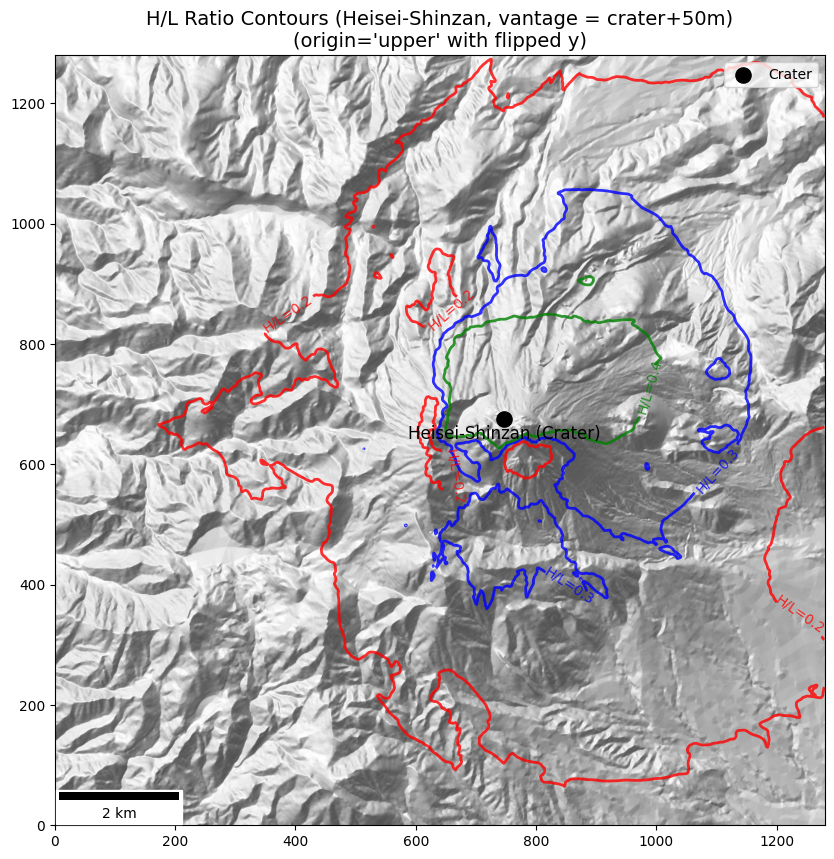

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LightSource

dem_url_template = "https://cyberjapandata.gsi.go.jp/xyz/dem/{z}/{x}/{y}.txt"

crater_lat, crater_lon = 32.7621, 130.2961
crater_height = 1483
vantage_height = crater_height + 30
zoom = 14

def latlon_to_tile(lat, lon, zoom):
    n = 2 ** zoom
    xtile = int((lon + 180.0) / 360.0 * n)
    ytile = int(
        (1.0 - np.log(np.tan(np.radians(lat)) + 1 / np.cos(np.radians(lat))) / np.pi)
        / 2.0
        * n
    )
    return xtile, ytile

def fetch_and_merge_tiles_corrected(x_center, y_center, z, tile_range):
    tiles = []
    for dy in range(-tile_range, tile_range + 1):
        row = []
        for dx in range(-tile_range, tile_range + 1):
            try:
                x, y = x_center + dx, y_center + dy
                url = dem_url_template.format(z=z, x=x, y=y)
                response = requests.get(url)
                if response.status_code == 200:
                    data = []
                    for line in response.text.splitlines():
                        vals = [float(val) if val != "e" else np.nan
                                for val in line.split(",")]
                        data.append(vals)
                    row.append(np.array(data, dtype=np.float32))
                else:
                    row.append(np.full((256, 256), np.nan, dtype=np.float32))
            except Exception as e:
                row.append(np.full((256, 256), np.nan, dtype=np.float32))
        tiles.append(np.hstack(row))
    return np.vstack(tiles)

# ---------------------
# 【ここが重要】上下を反転させる仕組み
# ---------------------
def latlon_to_pixel(lat, lon, xtile, ytile, zoom, tile_range, dem_shape):
    """
    dem_shape: (height, width) = dem_data.shape
    """
    n = 2 ** zoom
    tile_size = 256
    x_geo = (lon + 180.0) / 360.0 * n * tile_size
    y_geo = (
        (1.0 - np.log(np.tan(np.radians(lat)) + 1 / np.cos(np.radians(lat))) / np.pi)
        / 2.0
        * n
        * tile_size
    )
    x_pixel = x_geo - (xtile - tile_range) * tile_size
    y_pixel = y_geo - (ytile - tile_range) * tile_size

    # Matplotlibのorigin='upper'に合わせるために上下反転
    y_pixel_flipped = dem_shape[0] - y_pixel

    return int(x_pixel), int(y_pixel_flipped)

# ---------------------
# メイン処理
# ---------------------
xtile, ytile = latlon_to_tile(crater_lat, crater_lon, zoom)
tile_range = 2
dem_data = fetch_and_merge_tiles_corrected(xtile, ytile, zoom, tile_range)

# ここで dem_data.shape を引数にして呼び出す
crater_x, crater_y = latlon_to_pixel(crater_lat, crater_lon, xtile, ytile,
                                     zoom, tile_range, dem_data.shape)

ny, nx = dem_data.shape
x_coords = np.arange(nx)
y_coords = np.arange(ny)
X, Y = np.meshgrid(x_coords, y_coords)

def calculate_ratio_h_over_l(dem_data, crater_x, crater_y, vantage_height, mesh_size):
    distance = np.sqrt((X - crater_x)**2 + (Y - crater_y)**2) * mesh_size
    height_diff = vantage_height - dem_data
    distance[distance == 0] = np.nan
    ratio = height_diff / distance
    return ratio

mesh_size = 10
ratio_data = calculate_ratio_h_over_l(dem_data, crater_x, crater_y, vantage_height, mesh_size)

# ヒルシェード
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem_data, vert_exag=1, dx=1, dy=1)

fig, ax = plt.subplots(figsize=(10, 10))

# origin='upper' (デフォルト) で描画
terrain = ax.imshow(
    hillshade,
    cmap="gray",
    alpha=0.7,
    extent=[0, nx, 0, ny],
    origin="upper"  # ここを変えない
)

# 等値線は levels を昇順に
levels = [0.2, 0.3, 0.4]
contour_set = ax.contour(
    X, Y, ratio_data,
    levels=levels,
    colors=['red', 'blue', 'green'],
    linewidths=2,
    alpha=0.8,
    origin="upper"  # contour も同様に合わせる
)
ax.clabel(contour_set, inline=True, fmt="H/L=%.1f", fontsize=10)

# 火口位置
ax.scatter(crater_x, crater_y, color="black", marker="o", s=120, label="Crater")
ax.text(
    crater_x, crater_y - 10, "Heisei-Shinzan (Crater)",
    color="black", fontsize=12, ha="center", va="top"
)

# スケールバー
scalebar = ScaleBar(10, units="m", location="lower left", scale_loc="bottom")
ax.add_artist(scalebar)

ax.set_title("H/L Ratio Contours (Heisei-Shinzan, vantage = crater+50m)\n(origin='upper' with flipped y)", fontsize=14)
ax.legend()
plt.show()


In [ ]:
!pip install matplotlib-scalebar


In [ ]:
!pip install cartopy

In [ ]:
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
import pycuda.autoinit
import plotly.graph_objects as go

# 以下に前述のコードを続けてください...

# Plotlyでインタラクティブな3Dプロットを作成
fig = go.Figure()
colors = plt.cm.jet(np.linspace(0, 1, len(elevation_angles_deg)))

for i, el_idx in enumerate(range(len(elevation_angles_deg))):
    for az_idx in range(len(azimuths_deg)):
        trajectory_idx = az_idx * len(elevation_angles_deg) + el_idx
        fig.add_trace(go.Scatter3d(
            x=results_x[trajectory_idx],
            y=results_y[trajectory_idx],
            z=results_z[trajectory_idx],
            mode='lines',
            line=dict(color=f'rgb({colors[i][0]*255},{colors[i][1]*255},{colors[i][2]*255})'),
        ))

# レイアウト設定
fig.update_layout(
    scene=dict(
        xaxis_title='X (m)',
        yaxis_title='Y (m)',
        zaxis_title='Z (m)',
    ),
    title="Interactive 3D Ballistic Trajectories",
)

# 表示
fig.show()

# インタラクティブなプロットをHTMLファイルとして保存
pio.write_html(fig, file='interactive_3d_plot.html', auto_open=True)

ModuleNotFoundError: No module named 'pycuda'

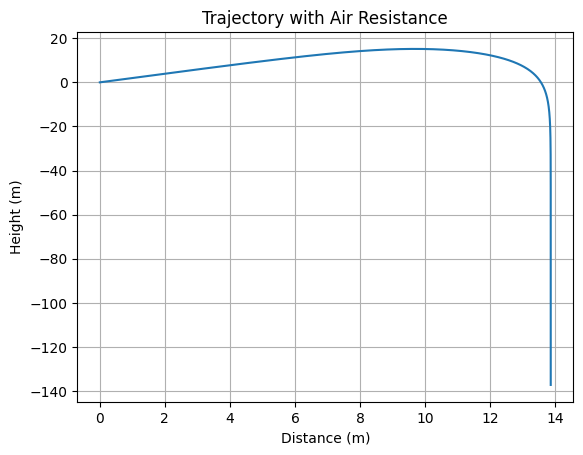

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 定数
g = 9.81  # 重力加速度 (m/s^2)
rho = 1.225  # 空気密度 (kg/m^3)
CD = 0.47  # 抗力係数
d = 0.3  # 球の直径 (m)
A = np.pi * (d / 2)**2  # 断面積 (m^2)
m = 0.145  # 質量 (kg)

# 初期条件
v0 = 100.0  # 初速度 (m/s)
angle = 63.0  # 発射角度 (度)
theta = np.radians(angle)

# 初速度のx, y成分
vx0 = v0 * np.cos(theta)
vy0 = v0 * np.sin(theta)

# 初期状態ベクトル
y0 = [0.0, 0.0, vx0, vy0]  # [x0, y0, vx0, vy0]

# 微分方程式の定義
def equations(t, y):
    x, y, vx, vy = y
    v = np.sqrt(vx**2 + vy**2)
    Fd = 0.5 * rho * v**2 * CD * A
    ax = -Fd * vx / (m * v)
    ay = -g - (Fd * vy / (m * v))
    return [vx, vy, ax, ay]

# 時間範囲
t_span = (0, 20)  # 0から20秒の範囲で計算
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # 評価時間点

# 解を求める
sol = solve_ivp(equations, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-8)

# 結果をプロット
plt.figure()
plt.plot(sol.y[0], sol.y[1])
plt.title('Trajectory with Air Resistance')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.grid(True)
plt.show()


In [ ]:
!pip install pycuda


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=6bd5c86adcffb9ceb572d9100f0c08db8db445496f22c97609a0dca4513b6628
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


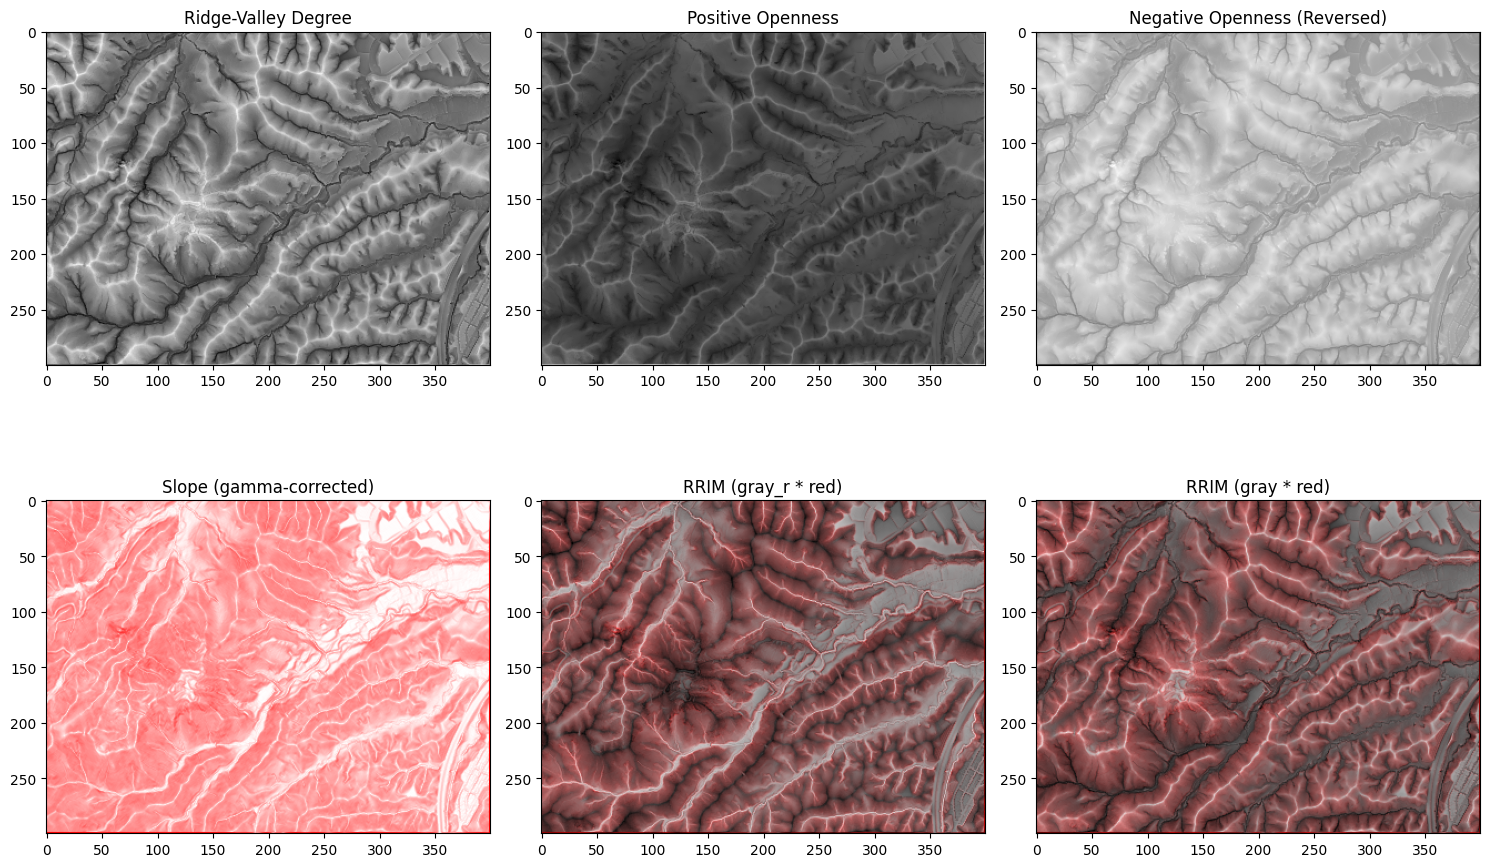

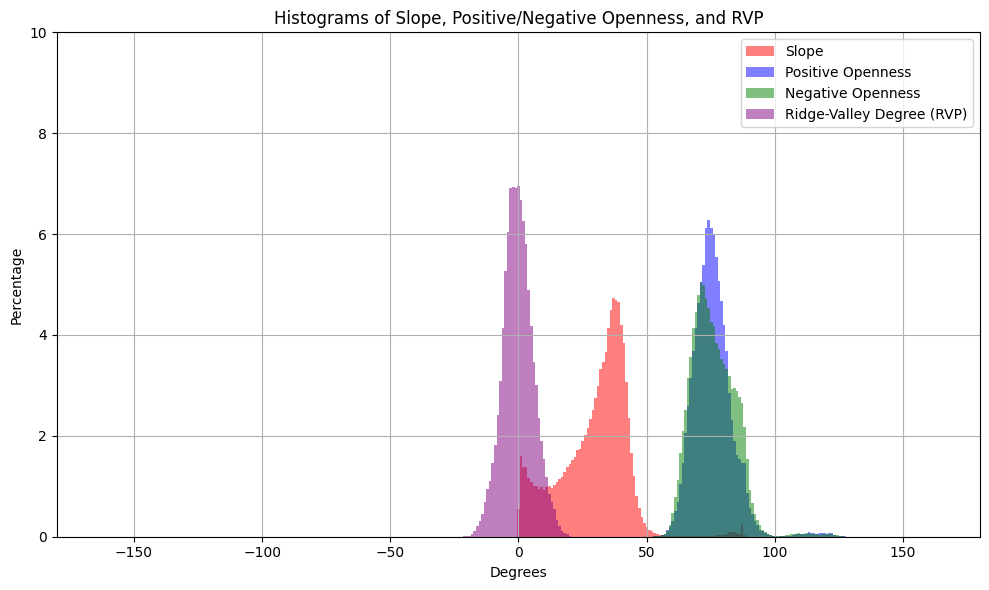

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import urllib.request
from skimage.exposure import adjust_gamma
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime

# ▼▼▼ ここがポイント: Numbaの導入 ▼▼▼
from numba import njit, prange


# ===================================================
#  1. カスタムカラーマップなど事前準備
# ===================================================

# 赤いカラーマップの作成 (オリジナル通り)
cmap_red = LinearSegmentedColormap.from_list('red', ['white', 'red'])

def adjust_contrast(array, min_val, max_val, gamma=1.0):
    """
    [min_val, max_val] の範囲を [0,1] に正規化し、ガンマ補正をかけて返す。
    """
    denom = (max_val - min_val) if (max_val - min_val) != 0 else 1e-10
    normed = (array - min_val) / denom
    normed = np.clip(normed, 0, 1)
    # skimage.exposure の adjust_gamma を呼んでもOKですが、
    # numbaの対象外なので、そのままnumpyのpowを使っても可
    adjusted = adjust_gamma(normed, gamma=gamma)
    return adjusted


# ===================================================
#  2. DEMの各種解析関数
# ===================================================

def calculate_slope(dem, pixel_size_x, pixel_size_y):
    """
    中央差分法を使って傾斜(度数法)を計算する関数
    """
    dz_dx = (np.roll(dem, -1, axis=1) - np.roll(dem, 1, axis=1)) / (2 * pixel_size_x)
    dz_dy = (np.roll(dem, -1, axis=0) - np.roll(dem, 1, axis=0)) / (2 * pixel_size_y)

    gradient = np.sqrt(dz_dx**2 + dz_dy**2)
    slope_degrees = np.arctan(gradient) * (180 / np.pi)

    # DEMがNaNの場所は傾斜もNaNに
    nan_mask = np.isnan(dem)
    slope_degrees[nan_mask] = np.nan
    return slope_degrees


# --- 8方向のdx, dy を numba が処理しやすい形で定義 ---
directions = np.array([
    (-1,  0),  # 北
    ( 1,  0),  # 南
    ( 0, -1),  # 西
    ( 0,  1),  # 東
    (-1, -1),  # 北西
    (-1,  1),  # 北東
    ( 1, -1),  # 南西
    ( 1,  1)   # 南東
], dtype=np.int32)


@njit(parallel=True)
def calculate_ridge_valley_openness_fast(dem, consideration_distance, px_size_x, px_size_y):
    """
    各ピクセルについて:
      1) Positive Openness (demそのまま)
      2) Negative Openness (-dem で裏返し)
    を求め、(Positive - Negative)/2 で表される
    Ridge-Valley Degree (RVD) を並列ループ(prange)で高速に算出。
    """

    rows, cols = dem.shape

    # 初期値 180.0（=真横より下）
    pos_open = np.full((rows, cols), 180.0, dtype=np.float32)
    neg_open = np.full((rows, cols), 180.0, dtype=np.float32)

    inverted_dem = -dem  # 負のDEM

    for y in prange(rows):  # prangeで並列化
        for x in range(cols):
            # DEMがNaNのところはOpennessもNaNに
            if np.isnan(dem[y, x]):
                pos_open[y, x] = np.nan
                neg_open[y, x] = np.nan
                continue

            center_height = dem[y, x]
            center_height_inv = inverted_dem[y, x]

            # 8方向の最小開度
            dir_open_arr = np.empty(8, dtype=np.float32)
            dir_open_arr_inv = np.empty(8, dtype=np.float32)

            # ===== (1) Positive Openness =====
            for d_i in range(8):
                dx = directions[d_i, 0]
                dy = directions[d_i, 1]
                min_open_angle = 180.0

                for step in range(1, consideration_distance + 1):
                    ny = y + dy * step
                    nx = x + dx * step

                    # 範囲外に出たら打ち切り
                    if ny < 0 or ny >= rows or nx < 0 or nx >= cols:
                        break

                    elev_diff = dem[ny, nx] - center_height
                    horiz_dist = np.sqrt((dx * px_size_x)**2 + (dy * px_size_y)**2) * step
                    if horiz_dist <= 0.0:
                        continue

                    slope_angle = np.degrees(np.arctan2(abs(elev_diff), horiz_dist))

                    if elev_diff > 0.0:
                        open_angle = 90.0 - slope_angle
                    elif elev_diff < 0.0:
                        open_angle = 90.0 + slope_angle
                    else:
                        open_angle = 90.0

                    if open_angle < min_open_angle:
                        min_open_angle = open_angle

                dir_open_arr[d_i] = min_open_angle

            pos_open[y, x] = np.mean(dir_open_arr)

            # ===== (2) Negative Openness =====
            for d_i in range(8):
                dx = directions[d_i, 0]
                dy = directions[d_i, 1]
                min_open_angle = 180.0

                for step in range(1, consideration_distance + 1):
                    ny = y + dy * step
                    nx = x + dx * step

                    if ny < 0 or ny >= rows or nx < 0 or nx >= cols:
                        break

                    elev_diff_inv = inverted_dem[ny, nx] - center_height_inv
                    horiz_dist = np.sqrt((dx * px_size_x)**2 + (dy * px_size_y)**2) * step
                    if horiz_dist <= 0.0:
                        continue

                    slope_angle_inv = np.degrees(np.arctan2(abs(elev_diff_inv), horiz_dist))

                    if elev_diff_inv > 0.0:
                        open_angle_inv = 90.0 - slope_angle_inv
                    elif elev_diff_inv < 0.0:
                        open_angle_inv = 90.0 + slope_angle_inv
                    else:
                        open_angle_inv = 90.0

                    if open_angle_inv < min_open_angle:
                        min_open_angle = open_angle_inv

                dir_open_arr_inv[d_i] = min_open_angle

            neg_open[y, x] = np.mean(dir_open_arr_inv)

    # Ridge-Valley Degree = (Positive - Negative) / 2
    rvd = (pos_open - neg_open) * 0.5
    return rvd, pos_open, neg_open


# ===================================================
#  3. GeoTIFF書き出し＆ヒストグラム表示関数
# ===================================================

def save_image_as_geotiff(image, output_file, dem_src, is_rgb=False):
    """
    画像データをGeoTIFF形式で保存する関数
    """
    if is_rgb:
        r = (image[..., 0] * 255).astype(np.uint8)
        g = (image[..., 1] * 255).astype(np.uint8)
        b = (image[..., 2] * 255).astype(np.uint8)

        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            height=image.shape[0],
            width=image.shape[1],
            count=3,
            dtype=np.uint8,
            crs=dem_src.crs,
            transform=dem_src.transform,
        ) as dst:
            dst.write(r, 1)
            dst.write(g, 2)
            dst.write(b, 3)
    else:
        image_8bit = (image * 255).astype(np.uint8)
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            height=image.shape[0],
            width=image.shape[1],
            count=1,
            dtype=np.uint8,
            crs=dem_src.crs,
            transform=dem_src.transform,
        ) as dst:
            dst.write(image_8bit, 1)


def plot_bar_histogram(data, bin_edges, label, color, alpha=0.5):
    """
    半透明の棒グラフヒストグラムを作成する関数
    """
    data_1d = data[~np.isnan(data)]
    counts, _ = np.histogram(data_1d, bins=bin_edges)
    counts = counts / counts.sum() * 100
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.bar(bin_centers, counts,
            width=bin_edges[1] - bin_edges[0],
            color=color, alpha=alpha, label=label)
    return np.max(counts)


# ===================================================
#  4. メイン処理 (DEMダウンロード -> 読込 -> 計算 -> 結果出力)
# ===================================================

if __name__ == "__main__":
    # --- 4.1 DEMファイルのURLとダウンロード先指定 ---
    dem_url = "https://paspro.com/bousai/kazan/_/bbs/?file_id=MV8wMDA4OTk=&name=5m.tif"
    dem_file = "dem.tif"

    urllib.request.urlretrieve(dem_url, dem_file)

    # --- 4.2 DEMを開いてデータ読み込み & NoData処理 ---
    with rasterio.open(dem_file) as src:
        dem_data = src.read(1).astype(np.float32)

        nodata_value = src.nodata
        if nodata_value is not None:
            dem_data[dem_data == nodata_value] = np.nan

        pixel_size_x = src.transform[0]
        pixel_size_y = abs(src.transform[4])  # 負値の可能性があるのでabs

    # --- 4.3 パラメータ指定 ---
    consideration_distance = 50  # 開度算出時に考慮する距離(ピクセル数)
    region_name = "sample_region"
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

    # --- 4.4 尾根谷度(RVP) & 開度計算 (★Numba並列化版)
    ridge_valley_degree, positive_openness, negative_openness = calculate_ridge_valley_openness_fast(
        dem_data, consideration_distance, pixel_size_x, pixel_size_y
    )

    # --- 4.5 傾斜(角度)計算 ---
    slope_degrees = calculate_slope(dem_data, pixel_size_x, pixel_size_y)

    # --- 4.6 コントラスト調整（RVP / 傾斜） ---
    rvp_min, rvp_max = np.nanmin(ridge_valley_degree), np.nanmax(ridge_valley_degree)
    gamma_corrected_rvp = adjust_contrast(ridge_valley_degree, rvp_min, rvp_max, gamma=1.0)

    gamma_corrected_slope = adjust_contrast(slope_degrees, 0, 90, gamma=1.0)

    # --- 4.7 画像合成 (gray系 × 赤カラーマップ)
    # (1) gray_r(尾根谷度) × red(傾斜)
    ridge_rgb_1 = plt.cm.gray_r(gamma_corrected_rvp)[..., :3]
    slope_rgb_1 = cmap_red(gamma_corrected_slope)[..., :3]

    rrim_image_1 = np.zeros_like(ridge_rgb_1)
    for i in range(3):
        rrim_image_1[..., i] = ridge_rgb_1[..., i] * slope_rgb_1[..., i]

    # (2) gray(尾根谷度) × red(傾斜)
    ridge_rgb_2 = plt.cm.gray(gamma_corrected_rvp)[..., :3]
    slope_rgb_2 = cmap_red(gamma_corrected_slope)[..., :3]

    rrim_image_2 = np.zeros_like(ridge_rgb_2)
    for i in range(3):
        rrim_image_2[..., i] = ridge_rgb_2[..., i] * slope_rgb_2[..., i]

    # --- 4.8 画像の表示 ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(ridge_valley_degree, cmap="gray")
    axes[0, 0].set_title("Ridge-Valley Degree")

    axes[0, 1].imshow(positive_openness, cmap="gray")
    axes[0, 1].set_title("Positive Openness")

    axes[0, 2].imshow(negative_openness, cmap="gray_r")
    axes[0, 2].set_title("Negative Openness (Reversed)")

    axes[1, 0].imshow(gamma_corrected_slope, cmap=cmap_red)
    axes[1, 0].set_title("Slope (gamma-corrected)")

    axes[1, 1].imshow(rrim_image_1)
    axes[1, 1].set_title("RRIM (gray_r * red)")

    axes[1, 2].imshow(rrim_image_2)
    axes[1, 2].set_title("RRIM (gray * red)")

    plt.tight_layout()
    plt.show()

    # --- 4.9 GeoTIFFとして出力 ---
    with rasterio.open(dem_file) as src:
        # モノクロ系
        save_image_as_geotiff(ridge_valley_degree,
                              f"ridge_valley_degree_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        save_image_as_geotiff(positive_openness,
                              f"positive_openness_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        save_image_as_geotiff(negative_openness,
                              f"negative_openness_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        save_image_as_geotiff(gamma_corrected_slope,
                              f"slope_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        # RGB (赤色立体地図)
        save_image_as_geotiff(rrim_image_1,
                              f"regular_rrim_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=True)

        save_image_as_geotiff(rrim_image_2,
                              f"inverted_rrim_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=True)

    # --- 4.10 ヒストグラム作成 ---
    bin_edges = np.linspace(-180, 180, 360)

    plt.figure(figsize=(10, 6))
    def plot_hist_and_getmax(data, bins, label, color):
        data_1d = data[~np.isnan(data)]
        counts, _ = np.histogram(data_1d, bins=bins)
        counts = counts / counts.sum() * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        plt.bar(bin_centers, counts, width=bins[1]-bins[0], alpha=0.5, label=label, color=color)
        return counts.max()

    slope_max = plot_hist_and_getmax(slope_degrees, bin_edges, "Slope", "red")
    pos_open_max = plot_hist_and_getmax(positive_openness, bin_edges, "Positive Openness", "blue")
    neg_open_max = plot_hist_and_getmax(negative_openness, bin_edges, "Negative Openness", "green")
    rvp_max = plot_hist_and_getmax(ridge_valley_degree, bin_edges, "Ridge-Valley Degree (RVP)", "purple")

    y_max = np.ceil(max(slope_max, pos_open_max, neg_open_max, rvp_max) / 10) * 10
    plt.xlim(-180, 180)
    plt.ylim(0, y_max)
    plt.xlabel("Degrees")
    plt.ylabel("Percentage")
    plt.title("Histograms of Slope, Positive/Negative Openness, and RVP")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import urllib.request
from skimage.exposure import adjust_gamma
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime

# ▼▼▼ ここがポイント: Numbaの導入 ▼▼▼
from numba import njit, prange


# ===================================================
#  1. カスタムカラーマップなど事前準備
# ===================================================

# 赤いカラーマップの作成 (オリジナル通り)
cmap_red = LinearSegmentedColormap.from_list('red', ['white', 'red'])

def adjust_contrast(array, min_val, max_val, gamma=1.0):
    """
    [min_val, max_val] の範囲を [0,1] に正規化し、ガンマ補正をかけて返す。
    """
    denom = (max_val - min_val) if (max_val - min_val) != 0 else 1e-10
    normed = (array - min_val) / denom
    normed = np.clip(normed, 0, 1)
    # skimage.exposure の adjust_gamma を呼んでもOKですが、
    # numbaの対象外なので、そのままnumpyのpowを使っても可
    adjusted = adjust_gamma(normed, gamma=gamma)
    return adjusted


# ===================================================
#  2. DEMの各種解析関数
# ===================================================

def calculate_slope(dem, pixel_size_x, pixel_size_y):
    """
    中央差分法を使って傾斜(度数法)を計算する関数
    """
    dz_dx = (np.roll(dem, -1, axis=1) - np.roll(dem, 1, axis=1)) / (2 * pixel_size_x)
    dz_dy = (np.roll(dem, -1, axis=0) - np.roll(dem, 1, axis=0)) / (2 * pixel_size_y)

    gradient = np.sqrt(dz_dx**2 + dz_dy**2)
    slope_degrees = np.arctan(gradient) * (180 / np.pi)

    # DEMがNaNの場所は傾斜もNaNに
    nan_mask = np.isnan(dem)
    slope_degrees[nan_mask] = np.nan
    return slope_degrees


# --- 8方向のdx, dy を numba が処理しやすい形で定義 ---
directions = np.array([
    (-1,  0),  # 北
    ( 1,  0),  # 南
    ( 0, -1),  # 西
    ( 0,  1),  # 東
    (-1, -1),  # 北西
    (-1,  1),  # 北東
    ( 1, -1),  # 南西
    ( 1,  1)   # 南東
], dtype=np.int32)


@njit(parallel=True)
def calculate_ridge_valley_openness_fast(dem, consideration_distance, px_size_x, px_size_y):
    """
    各ピクセルについて:
      1) Positive Openness (demそのまま)
      2) Negative Openness (-dem で裏返し)
    を求め、(Positive - Negative)/2 で表される
    Ridge-Valley Degree (RVD) を並列ループ(prange)で高速に算出。
    """

    rows, cols = dem.shape

    # 初期値 180.0（=真横より下）
    pos_open = np.full((rows, cols), 180.0, dtype=np.float32)
    neg_open = np.full((rows, cols), 180.0, dtype=np.float32)

    inverted_dem = -dem  # 負のDEM

    for y in prange(rows):  # prangeで並列化
        for x in range(cols):
            # DEMがNaNのところはOpennessもNaNに
            if np.isnan(dem[y, x]):
                pos_open[y, x] = np.nan
                neg_open[y, x] = np.nan
                continue

            center_height = dem[y, x]
            center_height_inv = inverted_dem[y, x]

            # 8方向の最小開度
            dir_open_arr = np.empty(8, dtype=np.float32)
            dir_open_arr_inv = np.empty(8, dtype=np.float32)

            # ===== (1) Positive Openness =====
            for d_i in range(8):
                dx = directions[d_i, 0]
                dy = directions[d_i, 1]
                min_open_angle = 180.0

                for step in range(1, consideration_distance + 1):
                    ny = y + dy * step
                    nx = x + dx * step

                    # 範囲外に出たら打ち切り
                    if ny < 0 or ny >= rows or nx < 0 or nx >= cols:
                        break

                    elev_diff = dem[ny, nx] - center_height
                    horiz_dist = np.sqrt((dx * px_size_x)**2 + (dy * px_size_y)**2) * step
                    if horiz_dist <= 0.0:
                        continue

                    slope_angle = np.degrees(np.arctan2(abs(elev_diff), horiz_dist))

                    if elev_diff > 0.0:
                        open_angle = 90.0 - slope_angle
                    elif elev_diff < 0.0:
                        open_angle = 90.0 + slope_angle
                    else:
                        open_angle = 90.0

                    if open_angle < min_open_angle:
                        min_open_angle = open_angle

                dir_open_arr[d_i] = min_open_angle

            pos_open[y, x] = np.mean(dir_open_arr)

            # ===== (2) Negative Openness =====
            for d_i in range(8):
                dx = directions[d_i, 0]
                dy = directions[d_i, 1]
                min_open_angle = 180.0

                for step in range(1, consideration_distance + 1):
                    ny = y + dy * step
                    nx = x + dx * step

                    if ny < 0 or ny >= rows or nx < 0 or nx >= cols:
                        break

                    elev_diff_inv = inverted_dem[ny, nx] - center_height_inv
                    horiz_dist = np.sqrt((dx * px_size_x)**2 + (dy * px_size_y)**2) * step
                    if horiz_dist <= 0.0:
                        continue

                    slope_angle_inv = np.degrees(np.arctan2(abs(elev_diff_inv), horiz_dist))

                    if elev_diff_inv > 0.0:
                        open_angle_inv = 90.0 - slope_angle_inv
                    elif elev_diff_inv < 0.0:
                        open_angle_inv = 90.0 + slope_angle_inv
                    else:
                        open_angle_inv = 90.0

                    if open_angle_inv < min_open_angle:
                        min_open_angle = open_angle_inv

                dir_open_arr_inv[d_i] = min_open_angle

            neg_open[y, x] = np.mean(dir_open_arr_inv)

    # Ridge-Valley Degree = (Positive - Negative) / 2
    rvd = (pos_open - neg_open) * 0.5
    return rvd, pos_open, neg_open


# ===================================================
#  3. GeoTIFF書き出し＆ヒストグラム表示関数
# ===================================================

def save_image_as_geotiff(image, output_file, dem_src, is_rgb=False):
    """
    画像データをGeoTIFF形式で保存する関数
    """
    if is_rgb:
        r = (image[..., 0] * 255).astype(np.uint8)
        g = (image[..., 1] * 255).astype(np.uint8)
        b = (image[..., 2] * 255).astype(np.uint8)

        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            height=image.shape[0],
            width=image.shape[1],
            count=3,
            dtype=np.uint8,
            crs=dem_src.crs,
            transform=dem_src.transform,
        ) as dst:
            dst.write(r, 1)
            dst.write(g, 2)
            dst.write(b, 3)
    else:
        image_8bit = (image * 255).astype(np.uint8)
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            height=image.shape[0],
            width=image.shape[1],
            count=1,
            dtype=np.uint8,
            crs=dem_src.crs,
            transform=dem_src.transform,
        ) as dst:
            dst.write(image_8bit, 1)


def plot_bar_histogram(data, bin_edges, label, color, alpha=0.5):
    """
    半透明の棒グラフヒストグラムを作成する関数
    """
    data_1d = data[~np.isnan(data)]
    counts, _ = np.histogram(data_1d, bins=bin_edges)
    counts = counts / counts.sum() * 100
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.bar(bin_centers, counts,
            width=bin_edges[1] - bin_edges[0],
            color=color, alpha=alpha, label=label)
    return np.max(counts)


# ===================================================
#  4. メイン処理 (DEMダウンロード -> 読込 -> 計算 -> 結果出力)
# ===================================================

if __name__ == "__main__":
    # --- 4.1 DEMファイルのURLとダウンロード先指定 ---
    dem_url = "https://paspro.com/bousai/kazan/_/bbs/?file_id=MV8wMDA4OTk=&name=5m.tif"
    dem_file = "dem.tif"

    urllib.request.urlretrieve(dem_url, dem_file)

    # --- 4.2 DEMを開いてデータ読み込み & NoData処理 ---
    with rasterio.open(dem_file) as src:
        dem_data = src.read(1).astype(np.float32)

        nodata_value = src.nodata
        if nodata_value is not None:
            dem_data[dem_data == nodata_value] = np.nan

        pixel_size_x = src.transform[0]
        pixel_size_y = abs(src.transform[4])  # 負値の可能性があるのでabs

    # --- 4.3 パラメータ指定 ---
    consideration_distance = 50  # 開度算出時に考慮する距離(ピクセル数)
    region_name = "sample_region"
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

    # --- 4.4 尾根谷度(RVP) & 開度計算 (★Numba並列化版)
    ridge_valley_degree, positive_openness, negative_openness = calculate_ridge_valley_openness_fast(
        dem_data, consideration_distance, pixel_size_x, pixel_size_y
    )

    # --- 4.5 傾斜(角度)計算 ---
    slope_degrees = calculate_slope(dem_data, pixel_size_x, pixel_size_y)

    # --- 4.6 コントラスト調整（RVP / 傾斜） ---
    rvp_min, rvp_max = np.nanmin(ridge_valley_degree), np.nanmax(ridge_valley_degree)
    gamma_corrected_rvp = adjust_contrast(ridge_valley_degree, rvp_min, rvp_max, gamma=1.0)

    gamma_corrected_slope = adjust_contrast(slope_degrees, 0, 90, gamma=1.0)

    # --- 4.7 画像合成 (gray系 × 赤カラーマップ)
    # (1) gray_r(尾根谷度) × red(傾斜)
    ridge_rgb_1 = plt.cm.gray_r(gamma_corrected_rvp)[..., :3]
    slope_rgb_1 = cmap_red(gamma_corrected_slope)[..., :3]

    rrim_image_1 = np.zeros_like(ridge_rgb_1)
    for i in range(3):
        rrim_image_1[..., i] = ridge_rgb_1[..., i] * slope_rgb_1[..., i]

    # (2) gray(尾根谷度) × red(傾斜)
    ridge_rgb_2 = plt.cm.gray(gamma_corrected_rvp)[..., :3]
    slope_rgb_2 = cmap_red(gamma_corrected_slope)[..., :3]

    rrim_image_2 = np.zeros_like(ridge_rgb_2)
    for i in range(3):
        rrim_image_2[..., i] = ridge_rgb_2[..., i] * slope_rgb_2[..., i]

    # --- 4.8 画像の表示 ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(ridge_valley_degree, cmap="gray")
    axes[0, 0].set_title("Ridge-Valley Degree")

    axes[0, 1].imshow(positive_openness, cmap="gray")
    axes[0, 1].set_title("Positive Openness")

    axes[0, 2].imshow(negative_openness, cmap="gray_r")
    axes[0, 2].set_title("Negative Openness (Reversed)")

    axes[1, 0].imshow(gamma_corrected_slope, cmap=cmap_red)
    axes[1, 0].set_title("Slope (gamma-corrected)")

    axes[1, 1].imshow(rrim_image_1)
    axes[1, 1].set_title("RRIM (gray_r * red)")

    axes[1, 2].imshow(rrim_image_2)
    axes[1, 2].set_title("RRIM (gray * red)")

    plt.tight_layout()
    plt.show()

    # --- 4.9 GeoTIFFとして出力 ---
    with rasterio.open(dem_file) as src:
        # モノクロ系
        save_image_as_geotiff(ridge_valley_degree,
                              f"ridge_valley_degree_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        save_image_as_geotiff(positive_openness,
                              f"positive_openness_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        save_image_as_geotiff(negative_openness,
                              f"negative_openness_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        save_image_as_geotiff(gamma_corrected_slope,
                              f"slope_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=False)

        # RGB (赤色立体地図)
        save_image_as_geotiff(rrim_image_1,
                              f"regular_rrim_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=True)

        save_image_as_geotiff(rrim_image_2,
                              f"inverted_rrim_{region_name}_{consideration_distance}m_{current_time}.tif",
                              src, is_rgb=True)

    # --- 4.10 ヒストグラム作成 ---
    bin_edges = np.linspace(-180, 180, 360)

    plt.figure(figsize=(10, 6))
    def plot_hist_and_getmax(data, bins, label, color):
        data_1d = data[~np.isnan(data)]
        counts, _ = np.histogram(data_1d, bins=bins)
        counts = counts / counts.sum() * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        plt.bar(bin_centers, counts, width=bins[1]-bins[0], alpha=0.5, label=label, color=color)
        return counts.max()

    slope_max = plot_hist_and_getmax(slope_degrees, bin_edges, "Slope", "red")
    pos_open_max = plot_hist_and_getmax(positive_openness, bin_edges, "Positive Openness", "blue")
    neg_open_max = plot_hist_and_getmax(negative_openness, bin_edges, "Negative Openness", "green")
    rvp_max = plot_hist_and_getmax(ridge_valley_degree, bin_edges, "Ridge-Valley Degree (RVP)", "purple")

    y_max = np.ceil(max(slope_max, pos_open_max, neg_open_max, rvp_max) / 10) * 10
    plt.xlim(-180, 180)
    plt.ylim(0, y_max)
    plt.xlabel("Degrees")
    plt.ylabel("Percentage")
    plt.title("Histograms of Slope, Positive/Negative Openness, and RVP")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'rasterio'

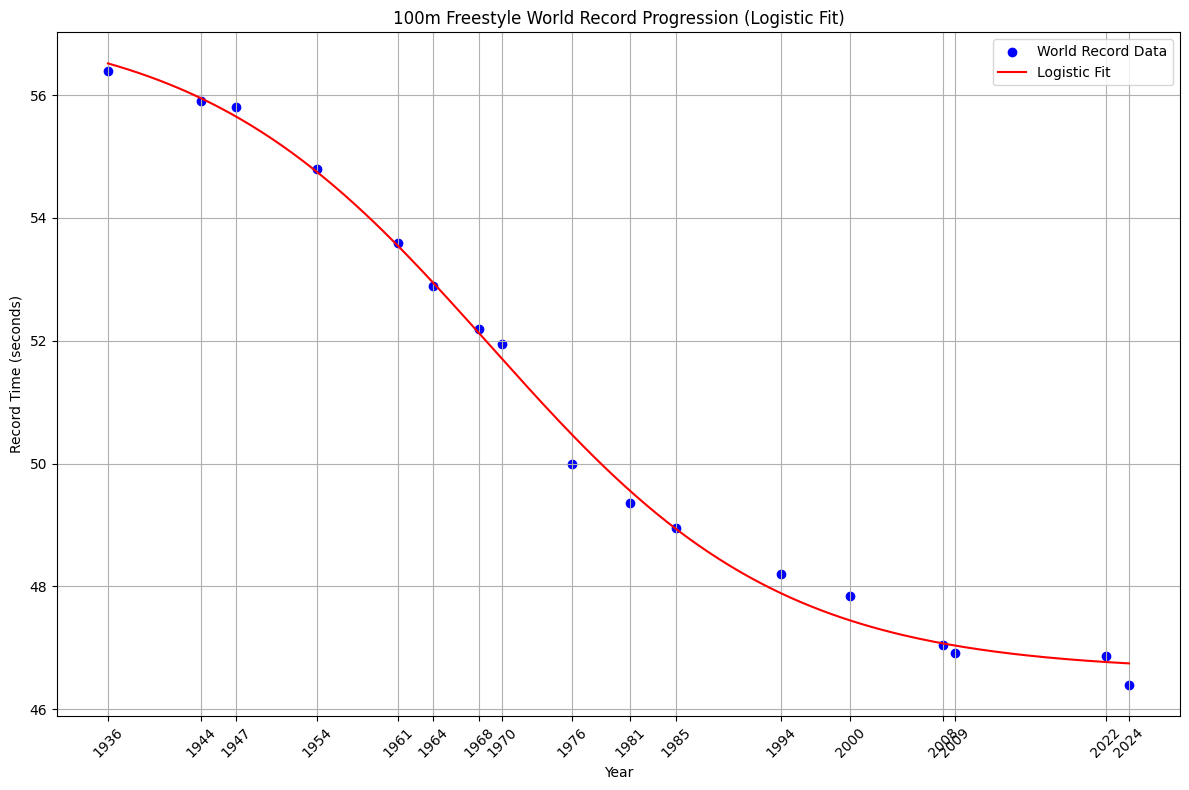

Fitted parameters [L, x0, k, b]:
[-1.06291406e+01  1.96890974e+03  7.94161177e-02  5.72433856e+01]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# データ：100m自由形の世界記録推移
data = {
    "Year": [1936, 1944, 1947, 1954, 1961, 1964, 1968, 1970, 1976, 1981, 1985, 1994, 2000, 2008, 2009, 2022, 2024],
    "Record (seconds)": [56.4, 55.9, 55.8, 54.8, 53.6, 52.9, 52.2, 51.94, 49.99, 49.36, 48.95, 48.21, 47.84, 47.05, 46.91, 46.86, 46.40]
}

# DataFrame を作成
df = pd.DataFrame(data)


# ロジスティック関数の定義
def logistic_function(x, L, x0, k, b):
    """
    L: ロジスティック曲線の最大振幅
    x0: 曲線の中心 (転換点)
    k: 成長率 (傾き)
    b: オフセット
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

# x_data, y_data を定義
x_data = df["Year"].values
y_data = df["Record (seconds)"].values

# curve_fit でロジスティック関数をフィット
# 初期推定値 p0 は適宜調整が必要
popt, pcov = curve_fit(logistic_function, x_data, y_data, p0=[50, 1970, 0.1, 45])

# フィット結果を用いて曲線描画用の X, Y を生成
x_fit = np.linspace(min(x_data), max(x_data), 200)
y_fit = logistic_function(x_fit, *popt)

# フィット後のデータと曲線を重ねて表示
plt.figure(figsize=(12, 8))
plt.scatter(x_data, y_data, label='World Record Data', color='blue')
plt.plot(x_fit, y_fit, label='Logistic Fit', color='red')
plt.title('100m Freestyle World Record Progression (Logistic Fit)')
plt.xlabel('Year')
plt.ylabel('Record Time (seconds)')
plt.grid(True)
plt.xticks(x_data, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# フィットパラメータの表示
print("Fitted parameters [L, x0, k, b]:")
print(popt)


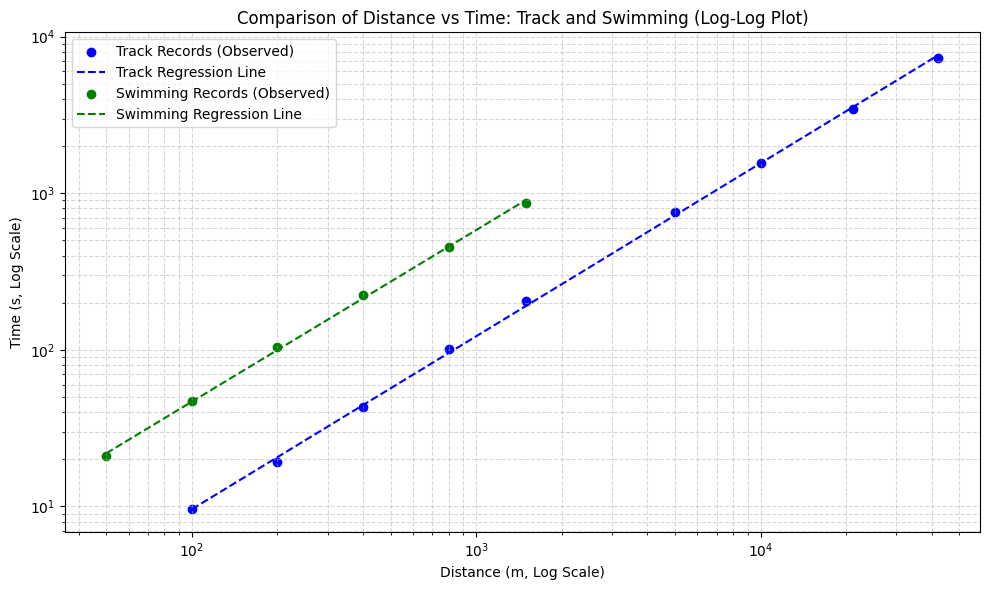

Track Regression: log10(T) = -1.2269 + 1.1047 * log10(D)
    → T = 10^(-1.2269) * D^(1.1047)
Swimming Regression: log10(T) = -0.5224 + 1.0959 * log10(D)
    → T = 10^(-0.5224) * D^(1.0959)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 陸上のデータ
distances_m_track = np.array([100, 200, 400, 800, 1500, 5000, 10000, 21097.5, 42195])
times_s_track = np.array([9.58, 19.19, 43.03, 100.91, 206.00, 755.36, 1571.0, 3451.0, 7269.0])

# 水泳のデータ (長水路)
distances_m_swim = np.array([50, 100, 200, 400, 800, 1500])
times_s_swim = np.array([20.91, 46.86, 103.85, 224.33, 452.12, 872.24])

# 両対数プロット用データ
logD_track = np.log10(distances_m_track)
logT_track = np.log10(times_s_track)
logD_swim = np.log10(distances_m_swim)
logT_swim = np.log10(times_s_swim)

# 陸上の回帰直線
beta_track, alpha_track = np.polyfit(logD_track, logT_track, 1)
logD_fit_track = np.linspace(min(logD_track), max(logD_track), 100)
logT_fit_track = alpha_track + beta_track * logD_fit_track

# 水泳の回帰直線
beta_swim, alpha_swim = np.polyfit(logD_swim, logT_swim, 1)
logD_fit_swim = np.linspace(min(logD_swim), max(logD_swim), 100)
logT_fit_swim = alpha_swim + beta_swim * logD_fit_swim

# グラフ描画
plt.figure(figsize=(10, 6))

# 陸上データ
plt.scatter(distances_m_track, times_s_track, color='blue', label='Track Records (Observed)')
plt.plot(10**logD_fit_track, 10**logT_fit_track, 'b--', label='Track Regression Line')

# 水泳データ
plt.scatter(distances_m_swim, times_s_swim, color='green', label='Swimming Records (Observed)')
plt.plot(10**logD_fit_swim, 10**logT_fit_swim, 'g--', label='Swimming Regression Line')

# 両対数スケール
plt.xscale('log')
plt.yscale('log')

# ラベルとタイトル
plt.xlabel('Distance (m, Log Scale)')
plt.ylabel('Time (s, Log Scale)')
plt.title('Comparison of Distance vs Time: Track and Swimming (Log-Log Plot)')

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 結果の表示
print("Track Regression: log10(T) = {:.4f} + {:.4f} * log10(D)".format(alpha_track, beta_track))
print("    → T = 10^({:.4f}) * D^({:.4f})".format(alpha_track, beta_track))
print("Swimming Regression: log10(T) = {:.4f} + {:.4f} * log10(D)".format(alpha_swim, beta_swim))
print("    → T = 10^({:.4f}) * D^({:.4f})".format(alpha_swim, beta_swim))


In [ ]:
import folium

# 東京駅の緯度と経度
tokyo_station_lat = 35.681236
tokyo_station_lon = 139.767125

# 地理院地図のタイル設定
gsi_tiles = 'https://cyberjapandata.gsi.go.jp/xyz/std/{z}/{x}/{y}.png'
gsi_attr = '地理院タイル'

# 地図の作成
m = folium.Map(
    location=[tokyo_station_lat, tokyo_station_lon],
    zoom_start=14,
    tiles=gsi_tiles,
    attr=gsi_attr
)

# 地図をHTMLとして保存
m.save('tokyo_station_map.html')

print("地図が'tokyo_station_map.html'に保存されました。ブラウザで開いてご確認ください。")


地図が'tokyo_station_map.html'に保存されました。ブラウザで開いてご確認ください。


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 97.1 MB/s eta 0:00:00


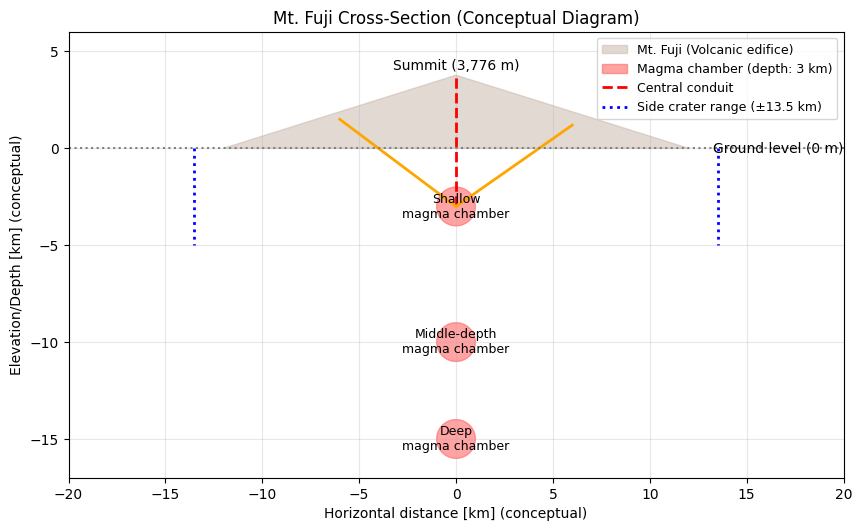

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_fujisan_section():
    # ---------------------------
    # 1. Basic settings
    # ---------------------------
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    # Coordinate range (conceptual)
    # Vertical (y-axis): from -17 km to about +6 km
    #   - Mt. Fuji summit ~ +3.776 km
    #   - We take some extra space above and below for a clearer view
    # Horizontal (x-axis): from -20 km to +20 km
    plt.xlim([-20, 20])
    plt.ylim([-17, 6])

    # ---------------------------
    # 2. Draw the volcanic edifice (Mt. Fuji)
    # ---------------------------
    # Simplify as a symmetric triangle:
    #   left base at (-12, 0), summit at (0, 3.776), right base at (12, 0)
    x_volcano = [-12, 0, 12]
    y_volcano = [  0, 3.776, 0]

    plt.fill(
        x_volcano,
        y_volcano,
        color="#c8b4a9",
        alpha=0.5,
        label='Mt. Fuji (Volcanic edifice)'
    )

    # ---------------------------
    # 3. Draw magma chambers at depths of -3 km, -10 km, and -15 km
    # ---------------------------
    # We'll assume each has a radius of ~1 km in this conceptual cross-section
    magma_chamber_centers = [(0, -3), (0, -10), (0, -15)]
    magma_chamber_radius = 1.0

    # Plot circles for each magma chamber
    theta = np.linspace(0, 2*np.pi, 200)
    for i, center in enumerate(magma_chamber_centers, start=1):
        cx, cy = center
        circle_x = cx + magma_chamber_radius * np.cos(theta)
        circle_y = cy + magma_chamber_radius * np.sin(theta)
        plt.fill(
            circle_x,
            circle_y,
            color="#ff6666",
            alpha=0.6,
            label='Magma chamber (depth: {} km)'.format(-cy) if i == 1 else ""
            # ラベルは一つだけ付与して重複を避ける
        )

    # ---------------------------
    # 4. Draw main conduit
    # ---------------------------
    # From the shallow magma chamber (at -3 km) to the summit (0, 3.776)
    x_main_conduit = [0, 0]
    y_main_conduit = [-3, 3.776]
    plt.plot(
        x_main_conduit,
        y_main_conduit,
        color='red',
        linestyle='--',
        linewidth=2,
        label='Central conduit'
    )

    # ---------------------------
    # 5. Draw some branch conduits (side vents)
    # ---------------------------
    # Example: from the shallow chamber (-3 km) to a point on the flank
    x_side1 = [0, 6]
    y_side1 = [-3, 1.2]
    plt.plot(x_side1, y_side1, color='orange', linestyle='-', linewidth=2)

    x_side2 = [0, -6]
    y_side2 = [-3, 1.5]
    plt.plot(x_side2, y_side2, color='orange', linestyle='-', linewidth=2)

    # ---------------------------
    # 6. Draw vertical lines at ±13.5 km (side crater limit)
    # ---------------------------
    # We will draw lines from y=0 (surface) down to, say, y=-5 or so (for clarity).
    # If you want them to go deeper, adjust accordingly.
    side_vent_limit = 13.5
    plt.vlines(
        x=side_vent_limit, ymin=0, ymax=-5,
        colors='blue', linestyles=':', linewidth=2,
        label='Side crater range (±13.5 km)'
    )
    plt.vlines(
        x=-side_vent_limit, ymin=0, ymax=-5,
        colors='blue', linestyles=':', linewidth=2
    )

    # ---------------------------
    # 7. Add annotations
    # ---------------------------
    # Summit annotation
    plt.text(
        0, 3.9, 'Summit (3,776 m)',
        ha='center', va='bottom', fontsize=10
    )
    # Ground surface annotation
    plt.hlines(
        y=0, xmin=-20, xmax=20,
        colors='gray', linestyles=':'
    )
    plt.text(
        20, 0, 'Ground level (0 m)',
        ha='right', va='center', fontsize=10
    )

    # Magma chamber annotations (just a rough label near them)
    plt.text(
        0, -3, 'Shallow\nmagma chamber',
        ha='center', va='center', fontsize=9, color='k'
    )
    plt.text(
        0, -10, 'Middle-depth\nmagma chamber',
        ha='center', va='center', fontsize=9, color='k'
    )
    plt.text(
        0, -15, 'Deep\nmagma chamber',
        ha='center', va='center', fontsize=9, color='k'
    )

    # Title
    plt.title("Mt. Fuji Cross-Section (Conceptual Diagram)", fontsize=12)

    # Legend
    plt.legend(loc='upper right', fontsize=9)

    # Axis labels
    plt.xlabel("Horizontal distance [km] (conceptual)")
    plt.ylabel("Elevation/Depth [km] (conceptual)")

    # Optional grid
    plt.grid(True, alpha=0.3)

    plt.show()

if __name__ == "__main__":
    draw_fujisan_section()


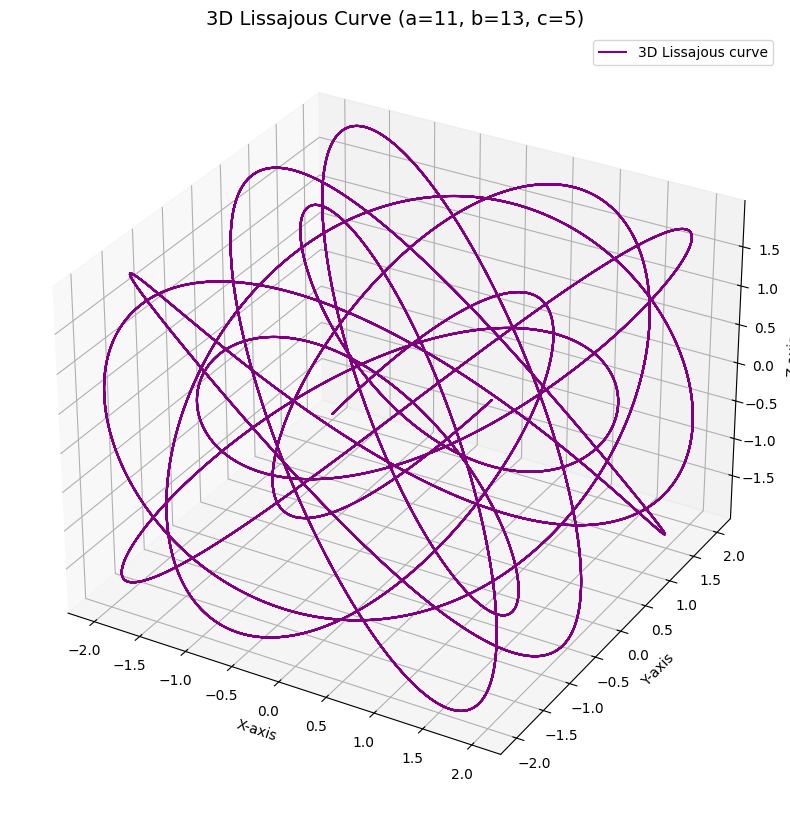

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# パラメータ
A = 2  # x軸の振幅
B = 2  # y軸の振幅
C = 2  # z軸の振幅
a = 19  # x軸の周波数
b = 13  # y軸の周波数
c = 23  # z軸の周波数

# 時間軸
t = np.linspace(0, 6 * np.pi, 10000)

# リサージュ曲線のx, y, z座標を計算
x = A * np.sin(a * t)
y = B * np.sin(b * t)
z = C * np.sin(c * t)

# 3Dプロット
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 曲線をプロット
ax.plot(x, y, z, color='purple', linewidth=1.5, label='3D Lissajous curve')

# 軸ラベル
ax.set_xlabel("X-axis", fontsize=10)
ax.set_ylabel("Y-axis", fontsize=10)
ax.set_zlabel("Z-axis", fontsize=10)
ax.set_title("3D Lissajous Curve (a=11, b=13, c=5)", fontsize=14)

# グリッドと凡例
ax.grid(True)
ax.legend()

# 表示
plt.show()
